In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [51]:
def load_dataset(path):
	
	data = pd.read_csv(path, header=3)
	timestamp = data.iloc[:, 0].to_numpy()
	output_voltage = data.iloc[:, 1].to_numpy()
	output_current = data.iloc[:, 2].to_numpy()
	thermistor_temperatures = data.iloc[:, 3:].to_numpy()

	comments = re.search(r"Comments: (.*)$", open(path).read(), re.MULTILINE)[1]

	return timestamp, output_voltage, output_current, thermistor_temperatures, comments

timestamp, output_voltage, output_current, thermistor_temperatures, comments = (
	load_dataset("../data/brass data/brass 2.5s.csv")
)

In [52]:
thermistor_num = [
    'thermistor_0/C',
    'thermistor_1/C',
    'thermistor_2/C',
    'thermistor_3/C',
    'thermistor_4/C',
    'thermistor_5/C',
    'thermistor_6/C',
    'thermistor_7/C'
]


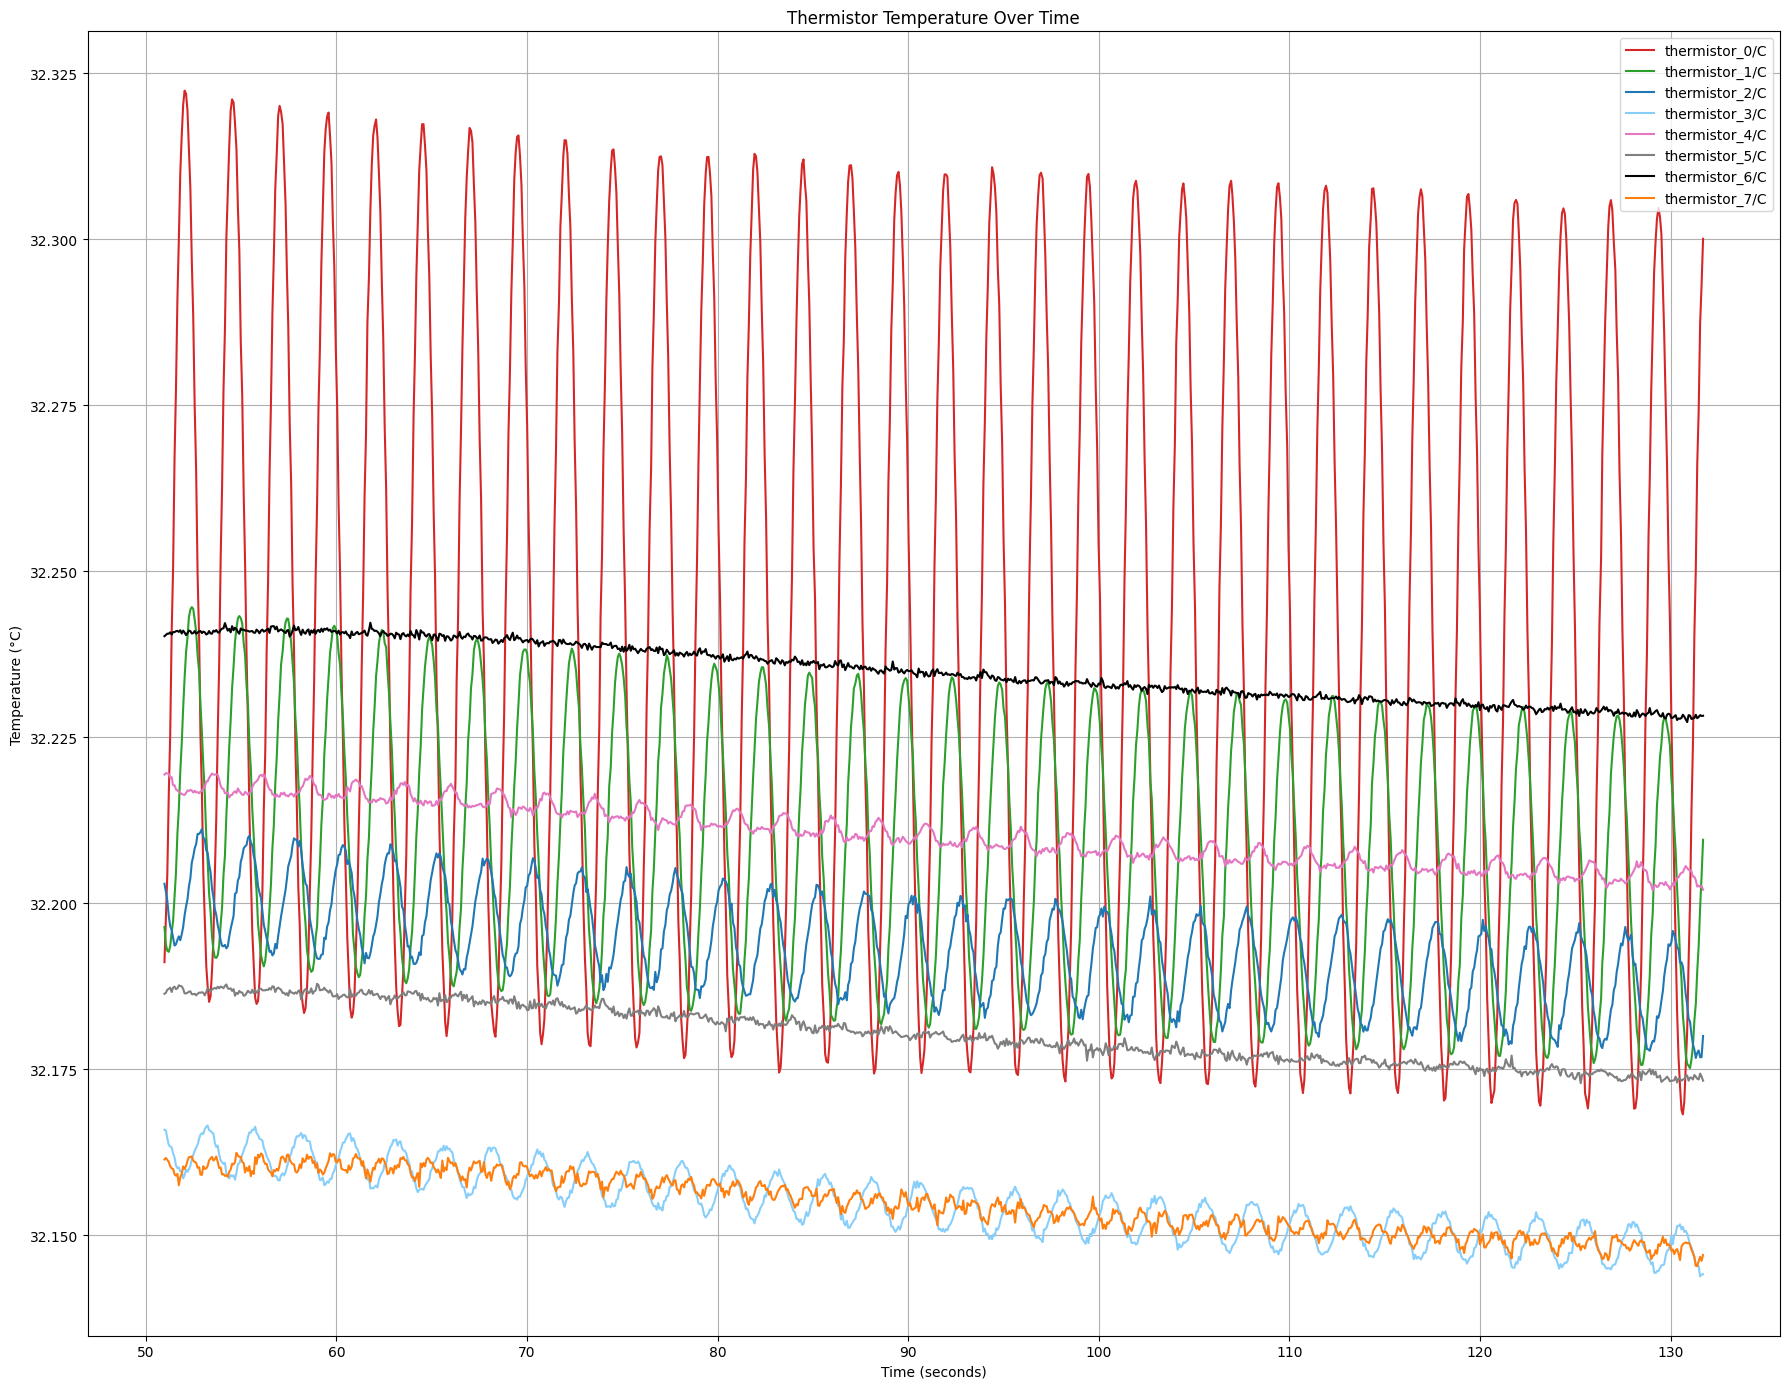

In [53]:
colors = ['tab:red', 'tab:green', 'tab:blue', 'lightskyblue', 
          'tab:pink', 'tab:gray', 'black', 'tab:orange']

plt.figure(figsize=(18, 14))

# Plot each thermistor's data with a different color and label
for i in range(8):
    plt.plot(timestamp, thermistor_temperatures[:,i], label=thermistor_num[i], color=colors[i])

plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.title('Thermistor Temperature Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [54]:
omega_guesses = [2 * np.pi / 2.5] * 8


Column 0 fit results:
  A     = 0.0681 ± 0.0001
  omega = 2.519653 ± 0.000044 rad/s
  phi   = 2.3238 ± 0.0042 rad
  B     = -0.000202 ± 0.000002 (slope)
  C     = 32.2623 ± 0.0002 (offset)
  Period = 2.4937 ± 0.0000 s


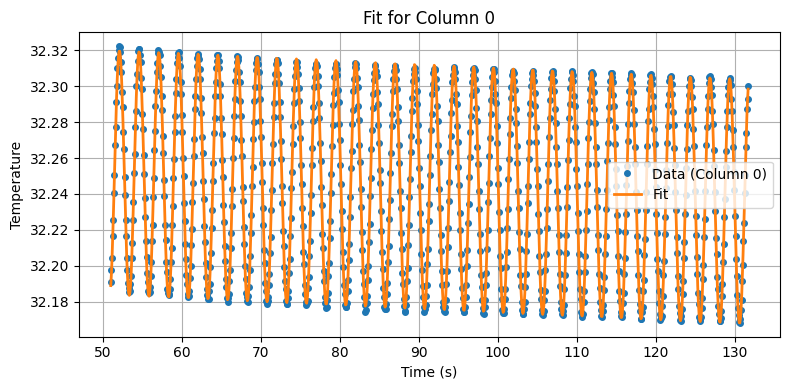


Column 1 fit results:
  A     = 0.0262 ± 0.0000
  omega = 2.519613 ± 0.000070 rad/s
  phi   = 1.4316 ± 0.0066 rad
  B     = -0.000200 ± 0.000001 (slope)
  C     = 32.2271 ± 0.0001 (offset)
  Period = 2.4937 ± 0.0001 s


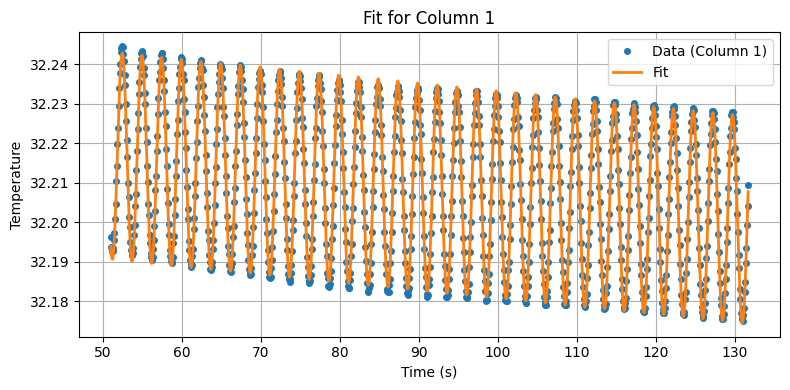


Column 2 fit results:
  A     = 0.0085 ± 0.0000
  omega = 2.519674 ± 0.000176 rad/s
  phi   = 0.2902 ± 0.0165 rad
  B     = -0.000198 ± 0.000001 (slope)
  C     = 32.2114 ± 0.0001 (offset)
  Period = 2.4936 ± 0.0002 s


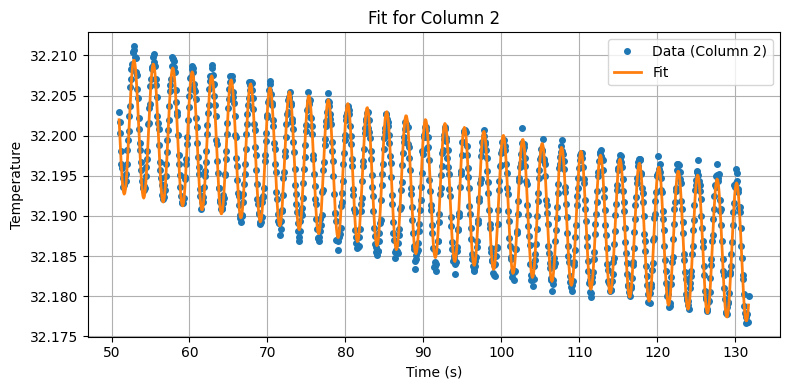


Column 3 fit results:
  A     = 0.0036 ± 0.0000
  omega = 2.519676 ± 0.000285 rad/s
  phi   = -0.5477 ± 0.0269 rad
  B     = -0.000194 ± 0.000001 (slope)
  C     = 32.1725 ± 0.0001 (offset)
  Period = 2.4936 ± 0.0003 s


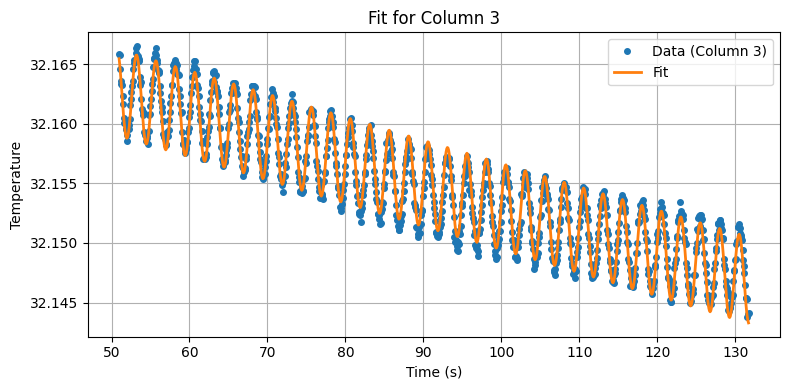


Column 4 fit results:
  A     = 0.0013 ± 0.0000
  omega = 2.519261 ± 0.000953 rad/s
  phi   = -1.2964 ± 0.0899 rad
  B     = -0.000190 ± 0.000001 (slope)
  C     = 32.2277 ± 0.0001 (offset)
  Period = 2.4941 ± 0.0009 s


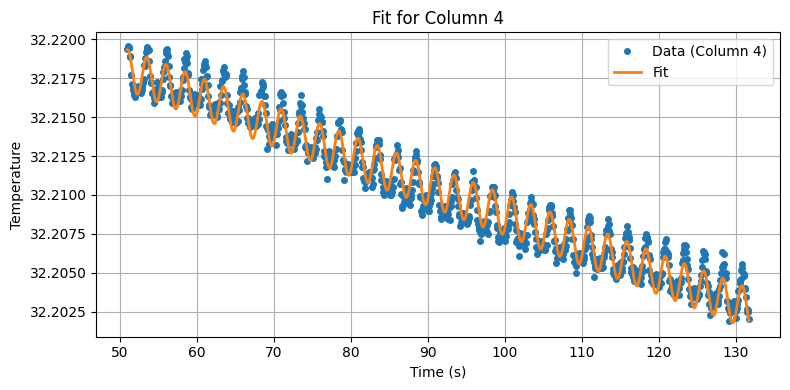


Column 5 fit results:
  A     = 0.0005 ± 0.0000
  omega = 2.518860 ± 0.002163 rad/s
  phi   = -2.4030 ± 0.2038 rad
  B     = -0.000186 ± 0.000001 (slope)
  C     = 32.1973 ± 0.0001 (offset)
  Period = 2.4945 ± 0.0021 s


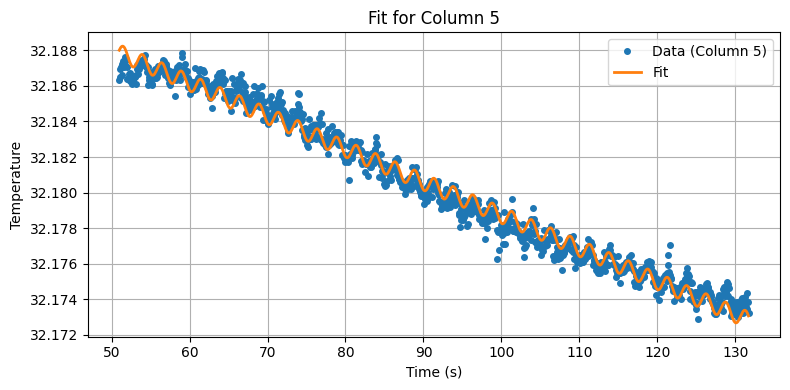


Column 6 fit results:
  A     = 0.0002 ± 0.0000
  omega = 2.527546 ± 0.005158 rad/s
  phi   = 2.0440 ± 0.4856 rad
  B     = -0.000184 ± 0.000001 (slope)
  C     = 32.2517 ± 0.0001 (offset)
  Period = 2.4859 ± 0.0051 s


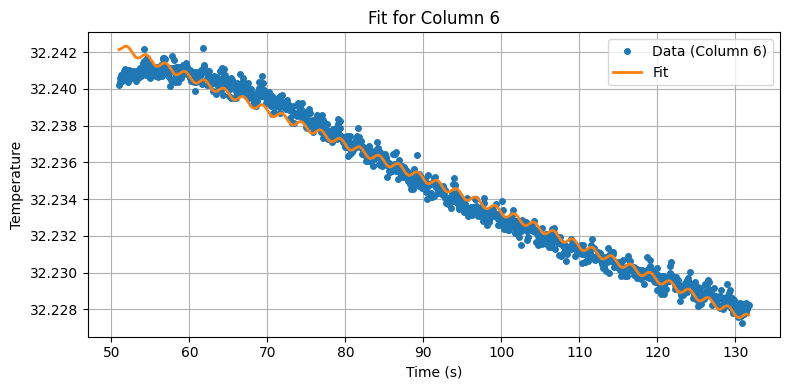


Column 7 fit results:
  A     = 0.0004 ± 0.0000
  omega = 2.519844 ± 0.004704 rad/s
  phi   = 0.2740 ± 0.4428 rad
  B     = -0.000183 ± 0.000001 (slope)
  C     = 32.1714 ± 0.0001 (offset)
  Period = 2.4935 ± 0.0047 s


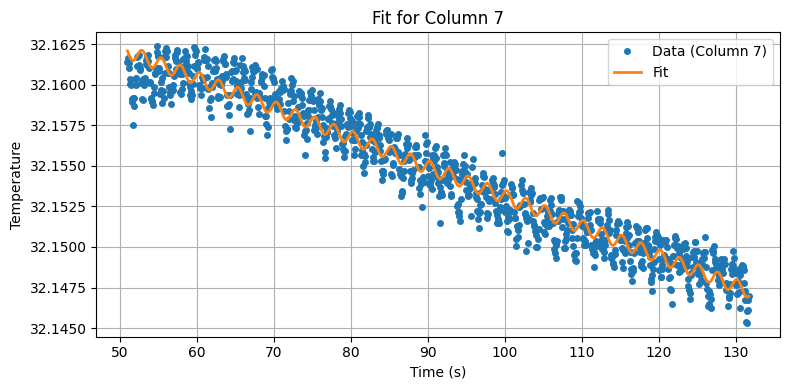

In [55]:
def sin_plus_line(t, A, omega, phi, B, C):
    return A * np.sin(omega * t + phi) + B * t + C

def initial_guess(t, y, omega_guess):
    A_guess = (np.max(y) - np.min(y)) / 2
    phi_guess = 0
    B_guess = 0  # Assuming no trend as initial guess
    C_guess = np.mean(y)
    return [A_guess, omega_guess, phi_guess, B_guess, C_guess]

n_columns = thermistor_temperatures.shape[1]
assert len(omega_guesses) == n_columns, "Length of omega_guesses must match number of columns"

fit_results = []  
for i in range(n_columns):
    y = thermistor_temperatures[:, i]
    omega_0 = omega_guesses[i]
    
    try:
        popt, pcov = curve_fit(
            sin_plus_line,
            timestamp,
            y,
            p0=initial_guess(timestamp, y, omega_0)
        )

        A, omega, phi, B, C = popt
        A, omega, phi, B, C = popt


        if A < 0:
          A = -A
          phi = phi + np.pi
          phi = (phi + np.pi) % (2*np.pi) - np.pi  

        perr = np.sqrt(np.diag(pcov))
        A_err, omega_err, phi_err, B_err, C_err = perr

        period = 2 * np.pi / omega if omega != 0 else np.nan
        period_err = (2 * np.pi / omega**2) * omega_err if omega != 0 else np.nan

        fit_results.append({
            'column': i,
            'A': (A, A_err),
            'omega': (omega, omega_err),
            'phi': (phi, phi_err),
            'B': (B, B_err),
            'C': (C, C_err),
            'period': (period, period_err)
        })

        print(f"\nColumn {i} fit results:")
        print(f"  A     = {A:.4f} ± {A_err:.4f}")
        print(f"  omega = {omega:.6f} ± {omega_err:.6f} rad/s")
        print(f"  phi   = {phi:.4f} ± {phi_err:.4f} rad")
        print(f"  B     = {B:.6f} ± {B_err:.6f} (slope)")
        print(f"  C     = {C:.4f} ± {C_err:.4f} (offset)")
        print(f"  Period = {period:.4f} ± {period_err:.4f} s")
        
        t_fit = np.linspace(min(timestamp), max(timestamp), 1000)
        y_fit = sin_plus_line(t_fit, *popt)

        plt.figure(figsize=(8, 4))
        plt.plot(timestamp, y, 'o', label=f'Data (Column {i})', markersize=4)
        plt.plot(t_fit, y_fit, '-', label='Fit', linewidth=2)
        plt.xlabel('Time (s)')
        plt.ylabel('Temperature')
        plt.title(f'Fit for Column {i}')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except RuntimeError as e:
        print(f"Fit failed for column {i}: {e}")
        fit_results.append({
            'column': i,
            'error': str(e)
        })


Column 0 fit results:
  A     = 0.0681 ± 0.0001
  omega = 2.519653 ± 0.000044 rad/s
  phi   = 2.3238 ± 0.0042 rad
  B     = -0.000202 ± 0.000002 (slope)
  C     = 32.2623 ± 0.0002 (offset)
  Period = 2.4937 ± 0.0000 s


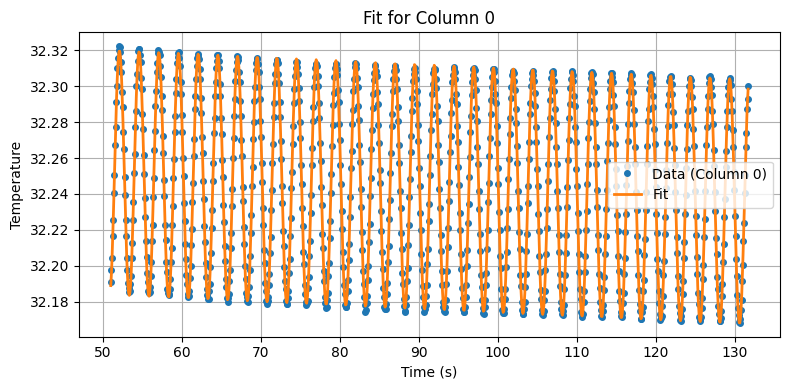


Column 1 fit results:
  A     = 0.0262 ± 0.0000
  omega = 2.519613 ± 0.000070 rad/s
  phi   = 1.4316 ± 0.0066 rad
  B     = -0.000200 ± 0.000001 (slope)
  C     = 32.2271 ± 0.0001 (offset)
  Period = 2.4937 ± 0.0001 s


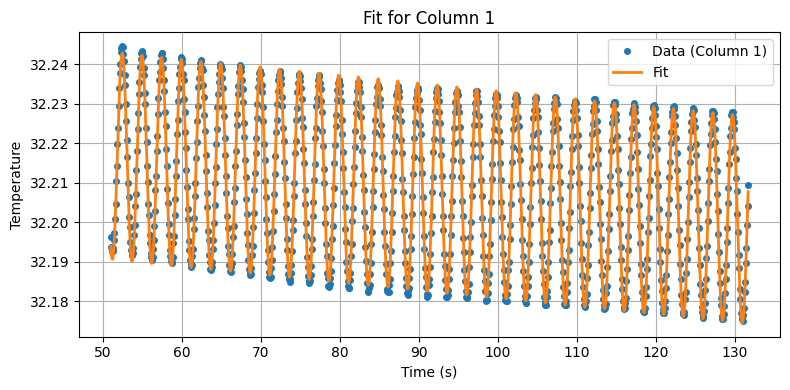


Column 2 fit results:
  A     = 0.0085 ± 0.0000
  omega = 2.519674 ± 0.000176 rad/s
  phi   = 0.2902 ± 0.0165 rad
  B     = -0.000198 ± 0.000001 (slope)
  C     = 32.2114 ± 0.0001 (offset)
  Period = 2.4936 ± 0.0002 s


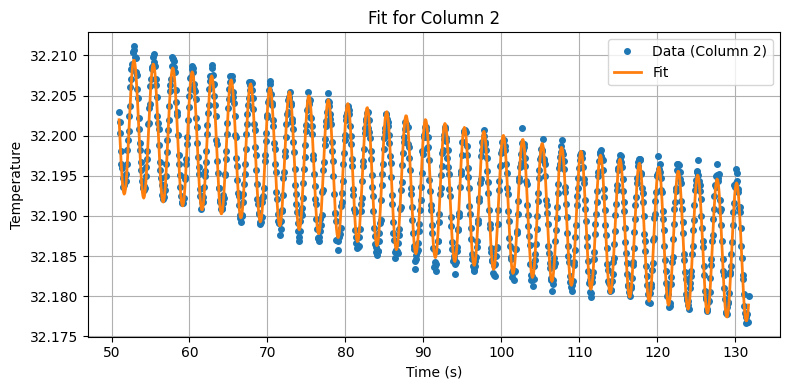


Column 3 fit results:
  A     = 0.0036 ± 0.0000
  omega = 2.519676 ± 0.000285 rad/s
  phi   = -0.5477 ± 0.0269 rad
  B     = -0.000194 ± 0.000001 (slope)
  C     = 32.1725 ± 0.0001 (offset)
  Period = 2.4936 ± 0.0003 s


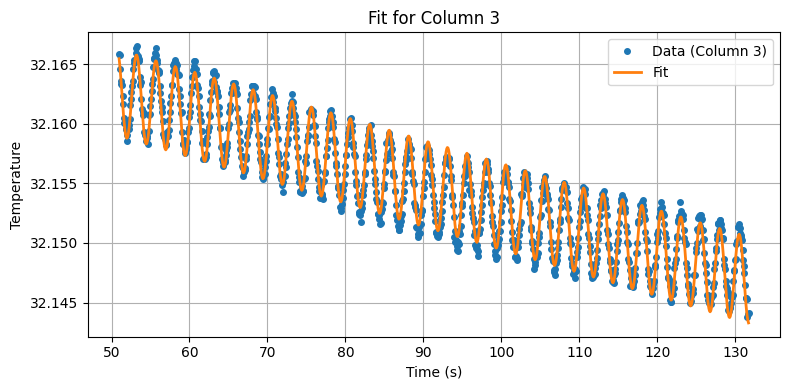


Column 4 fit results:
  A     = 0.0013 ± 0.0000
  omega = 2.519261 ± 0.000953 rad/s
  phi   = -1.2964 ± 0.0899 rad
  B     = -0.000190 ± 0.000001 (slope)
  C     = 32.2277 ± 0.0001 (offset)
  Period = 2.4941 ± 0.0009 s


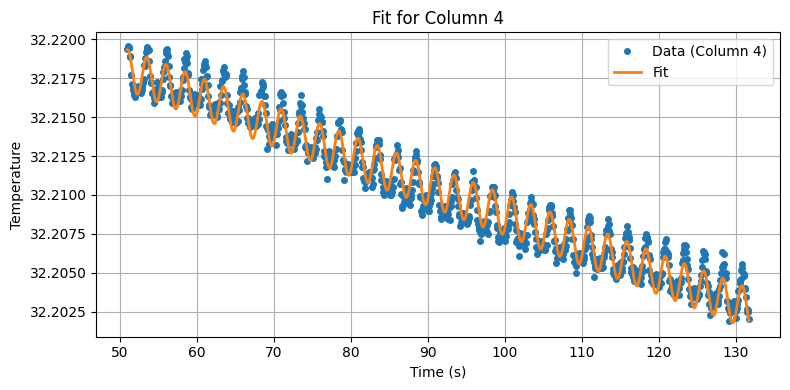


Column 5 fit results:
  A     = 0.0005 ± 0.0000
  omega = 2.518860 ± 0.002163 rad/s
  phi   = -2.4030 ± 0.2038 rad
  B     = -0.000186 ± 0.000001 (slope)
  C     = 32.1973 ± 0.0001 (offset)
  Period = 2.4945 ± 0.0021 s


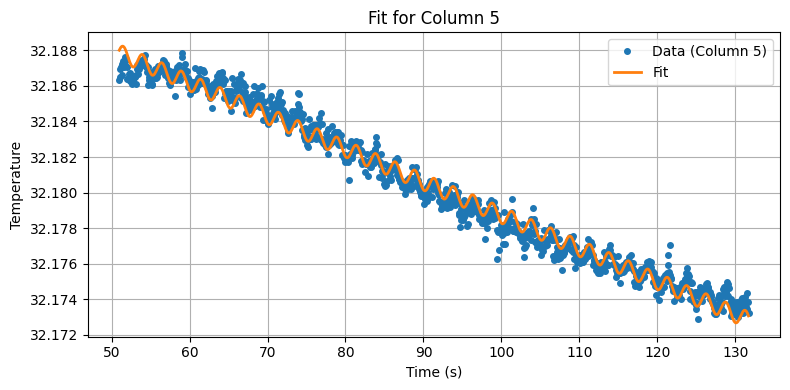


Column 6 fit results:
  A     = 0.0002 ± 0.0000
  omega = 2.527546 ± 0.005158 rad/s
  phi   = 2.0440 ± 0.4856 rad
  B     = -0.000184 ± 0.000001 (slope)
  C     = 32.2517 ± 0.0001 (offset)
  Period = 2.4859 ± 0.0051 s


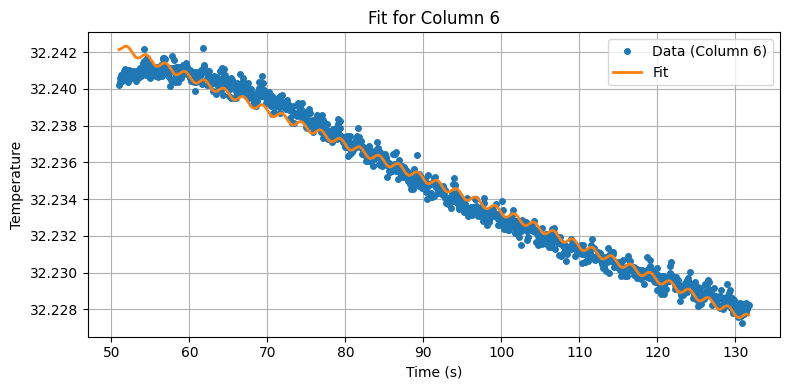


Column 7 fit results:
  A     = 0.0004 ± 0.0000
  omega = 2.519844 ± 0.004704 rad/s
  phi   = 0.2740 ± 0.4428 rad
  B     = -0.000183 ± 0.000001 (slope)
  C     = 32.1714 ± 0.0001 (offset)
  Period = 2.4935 ± 0.0047 s


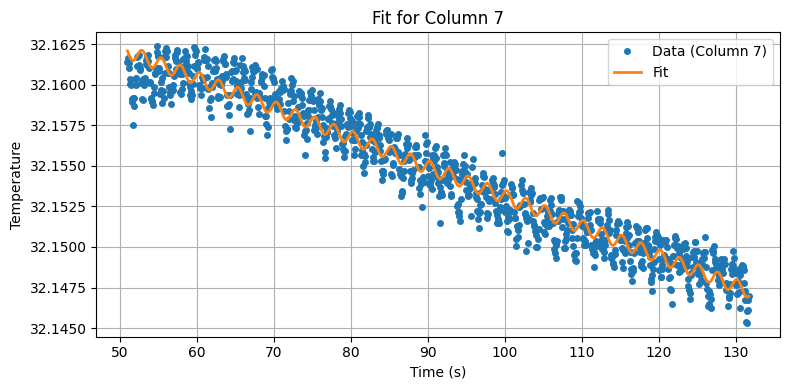

In [56]:
def sin_plus_line(t, A, omega, phi, B, C):
    return A * np.sin(omega * t + phi) + B * t + C

def initial_guess(t, y, omega_guess):
    A_guess = (np.max(y) - np.min(y)) / 2
    phi_guess = 0
    B_guess = 0  # Assuming no trend as initial guess
    C_guess = np.mean(y)
    return [A_guess, omega_guess, phi_guess, B_guess, C_guess]

n_columns = thermistor_temperatures.shape[1]
assert len(omega_guesses) == n_columns, "Length of omega_guesses must match number of columns"

fit_results = []  
for i in range(n_columns):
    y = thermistor_temperatures[:, i]
    omega_0 = omega_guesses[i]
    
    try:
        popt, pcov = curve_fit(
            sin_plus_line,
            timestamp,
            y,
            p0=initial_guess(timestamp, y, omega_0)
        )

        A, omega, phi, B, C = popt
        A, omega, phi, B, C = popt


        if A < 0:
          A = -A
          phi = phi + np.pi
          phi = (phi + np.pi) % (2*np.pi) - np.pi  

        perr = np.sqrt(np.diag(pcov))
        A_err, omega_err, phi_err, B_err, C_err = perr

        period = 2 * np.pi / omega if omega != 0 else np.nan
        period_err = (2 * np.pi / omega**2) * omega_err if omega != 0 else np.nan

        fit_results.append({
            'column': i,
            'A': (A, A_err),
            'omega': (omega, omega_err),
            'phi': (phi, phi_err),
            'B': (B, B_err),
            'C': (C, C_err),
            'period': (period, period_err)
        })

        print(f"\nColumn {i} fit results:")
        print(f"  A     = {A:.4f} ± {A_err:.4f}")
        print(f"  omega = {omega:.6f} ± {omega_err:.6f} rad/s")
        print(f"  phi   = {phi:.4f} ± {phi_err:.4f} rad")
        print(f"  B     = {B:.6f} ± {B_err:.6f} (slope)")
        print(f"  C     = {C:.4f} ± {C_err:.4f} (offset)")
        print(f"  Period = {period:.4f} ± {period_err:.4f} s")
        
        t_fit = np.linspace(min(timestamp), max(timestamp), 1000)
        y_fit = sin_plus_line(t_fit, *popt)

        plt.figure(figsize=(8, 4))
        plt.plot(timestamp, y, 'o', label=f'Data (Column {i})', markersize=4)
        plt.plot(t_fit, y_fit, '-', label='Fit', linewidth=2)
        plt.xlabel('Time (s)')
        plt.ylabel('Temperature')
        plt.title(f'Fit for Column {i}')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except RuntimeError as e:
        print(f"Fit failed for column {i}: {e}")
        fit_results.append({
            'column': i,
            'error': str(e)
        })

In [57]:
def error_percentages (i):
        y = thermistor_temperatures[:, i]
        omega_0 = omega_guesses[i]

        popt, pcov = curve_fit(
            sin_plus_line,
            timestamp,
            y,
            p0=initial_guess(timestamp, y, omega_0)
        )

        A, omega, phi, B, C = popt
        perr = np.sqrt(np.diag(pcov))
        A_err, omega_err, phi_err, B_err, C_err = perr
        return (perr/popt)

In [58]:
def sin_fit_val(i):
    
    y = thermistor_temperatures[:, i]
    omega_0 = omega_guesses[i]

    popt, pcov = curve_fit(
        sin_plus_line,
        timestamp,
        y,
        p0=initial_guess(timestamp, y, omega_0)
    )

    A, omega, phi, B, C = popt

    if A < 0:
        A = -A
        phi = phi + np.pi

        phi = (phi + np.pi) % (2 * np.pi) - np.pi

    return np.array([A, omega, phi, B, C])

In [59]:
for res in fit_results:
    if 'error' in res:
        print(f"\nColumn {res['column']}: Fit failed ({res['error']})")
    else:
        print(f"\nColumn {res['column']} fit results:")
        print(f"  A     = {res['A'][0]:.4f} ± {res['A'][1]:.4f}")
        print(f"  omega = {res['omega'][0]:.6f} ± {res['omega'][1]:.6f} rad/s")
        print(f"  phi   = {res['phi'][0]:.4f} ± {res['phi'][1]:.4f} rad")
        print(f"  B     = {res['B'][0]:.6f} ± {res['B'][1]:.6f} (slope)")
        print(f"  C     = {res['C'][0]:.4f} ± {res['C'][1]:.4f} (offset)")
        print(f"  Period = {res['period'][0]:.4f} ± {res['period'][1]:.4f} s")


Column 0 fit results:
  A     = 0.0681 ± 0.0001
  omega = 2.519653 ± 0.000044 rad/s
  phi   = 2.3238 ± 0.0042 rad
  B     = -0.000202 ± 0.000002 (slope)
  C     = 32.2623 ± 0.0002 (offset)
  Period = 2.4937 ± 0.0000 s

Column 1 fit results:
  A     = 0.0262 ± 0.0000
  omega = 2.519613 ± 0.000070 rad/s
  phi   = 1.4316 ± 0.0066 rad
  B     = -0.000200 ± 0.000001 (slope)
  C     = 32.2271 ± 0.0001 (offset)
  Period = 2.4937 ± 0.0001 s

Column 2 fit results:
  A     = 0.0085 ± 0.0000
  omega = 2.519674 ± 0.000176 rad/s
  phi   = 0.2902 ± 0.0165 rad
  B     = -0.000198 ± 0.000001 (slope)
  C     = 32.2114 ± 0.0001 (offset)
  Period = 2.4936 ± 0.0002 s

Column 3 fit results:
  A     = 0.0036 ± 0.0000
  omega = 2.519676 ± 0.000285 rad/s
  phi   = -0.5477 ± 0.0269 rad
  B     = -0.000194 ± 0.000001 (slope)
  C     = 32.1725 ± 0.0001 (offset)
  Period = 2.4936 ± 0.0003 s

Column 4 fit results:
  A     = 0.0013 ± 0.0000
  omega = 2.519261 ± 0.000953 rad/s
  phi   = -1.2964 ± 0.0899 rad
  B    

In [60]:
def error_from_two (a, b, quantity):
    a_errors_percentages = error_percentages(a)
    b_errors_percentages = error_percentages(b)
    result = np.sqrt((a_errors_percentages[quantity])**2 + (b_errors_percentages[quantity])**2)
    return result

In [61]:
def DA_DPhi(a, b):
    
    A_a, omega_a, phi_a, _, _ = sin_fit_val(a)
    A_b, omega_b, phi_b, _, _ = sin_fit_val(b)

    omega = np.mean([omega_a, omega_b])
    delta_d = 0.005 * np.abs(a - b)

    A_ratio = np.abs(A_b) / np.abs(A_a)
    delta_phi = np.abs(phi_b - phi_a)

    DA = omega * (delta_d)**2 / (2 * (np.log(A_ratio))**2)
    Dphi = omega * (delta_d)**2 / (2 * (delta_phi)**2)

    error_in_A_ratio = error_from_two(a, b, 0)      
    error_in_delta_phi = error_from_two(a, b, 2)    

    r_A = error_in_A_ratio / 100
    r_phi = error_in_delta_phi / 100

    DA_rel_error = 2 * r_A / np.abs(np.log(A_ratio))
    Dphi_rel_error = 2 * r_phi / np.abs(delta_phi)

    DA_error = DA * DA_rel_error
    Dphi_error = Dphi * Dphi_rel_error

    DA_error_percent = DA_rel_error * 100
    Dphi_error_percent = Dphi_rel_error * 100

    return {
        "DA": DA,
        "DA_error": DA_error,
        "DA_error_%": DA_error_percent,
        "Dphi": Dphi,
        "Dphi_error": Dphi_error,
        "Dphi_error_%": Dphi_error_percent
    }


In [62]:
DA_DPhi(0, 3)

{'DA': 3.290651816810246e-05,
 'DA_error': 1.5165806192609146e-09,
 'DA_error_%': 0.0046087544465004925,
 'Dphi': 3.43776816789899e-05,
 'Dphi_error': 1.1817376939203881e-08,
 'Dphi_error_%': 0.03437514213306051}

In [65]:
D = np.mean([3.290651816810246e-05, 3.43776816789899e-05])
D

3.364209992354618e-05

In [76]:
def load_dataset(path):
	
	data = pd.read_csv(path, header=3)
	timestamp = data.iloc[:, 0].to_numpy()
	output_voltage = data.iloc[:, 1].to_numpy()
	output_current = data.iloc[:, 2].to_numpy()
	thermistor_temperatures = data.iloc[:, 3:].to_numpy()

	comments = re.search(r"Comments: (.*)$", open(path).read(), re.MULTILINE)[1]

	return timestamp, output_voltage, output_current, thermistor_temperatures, comments

timestamp, output_voltage, output_current, thermistor_temperatures, comments = (
	load_dataset("../data/brass data/brass 30s.csv")
)

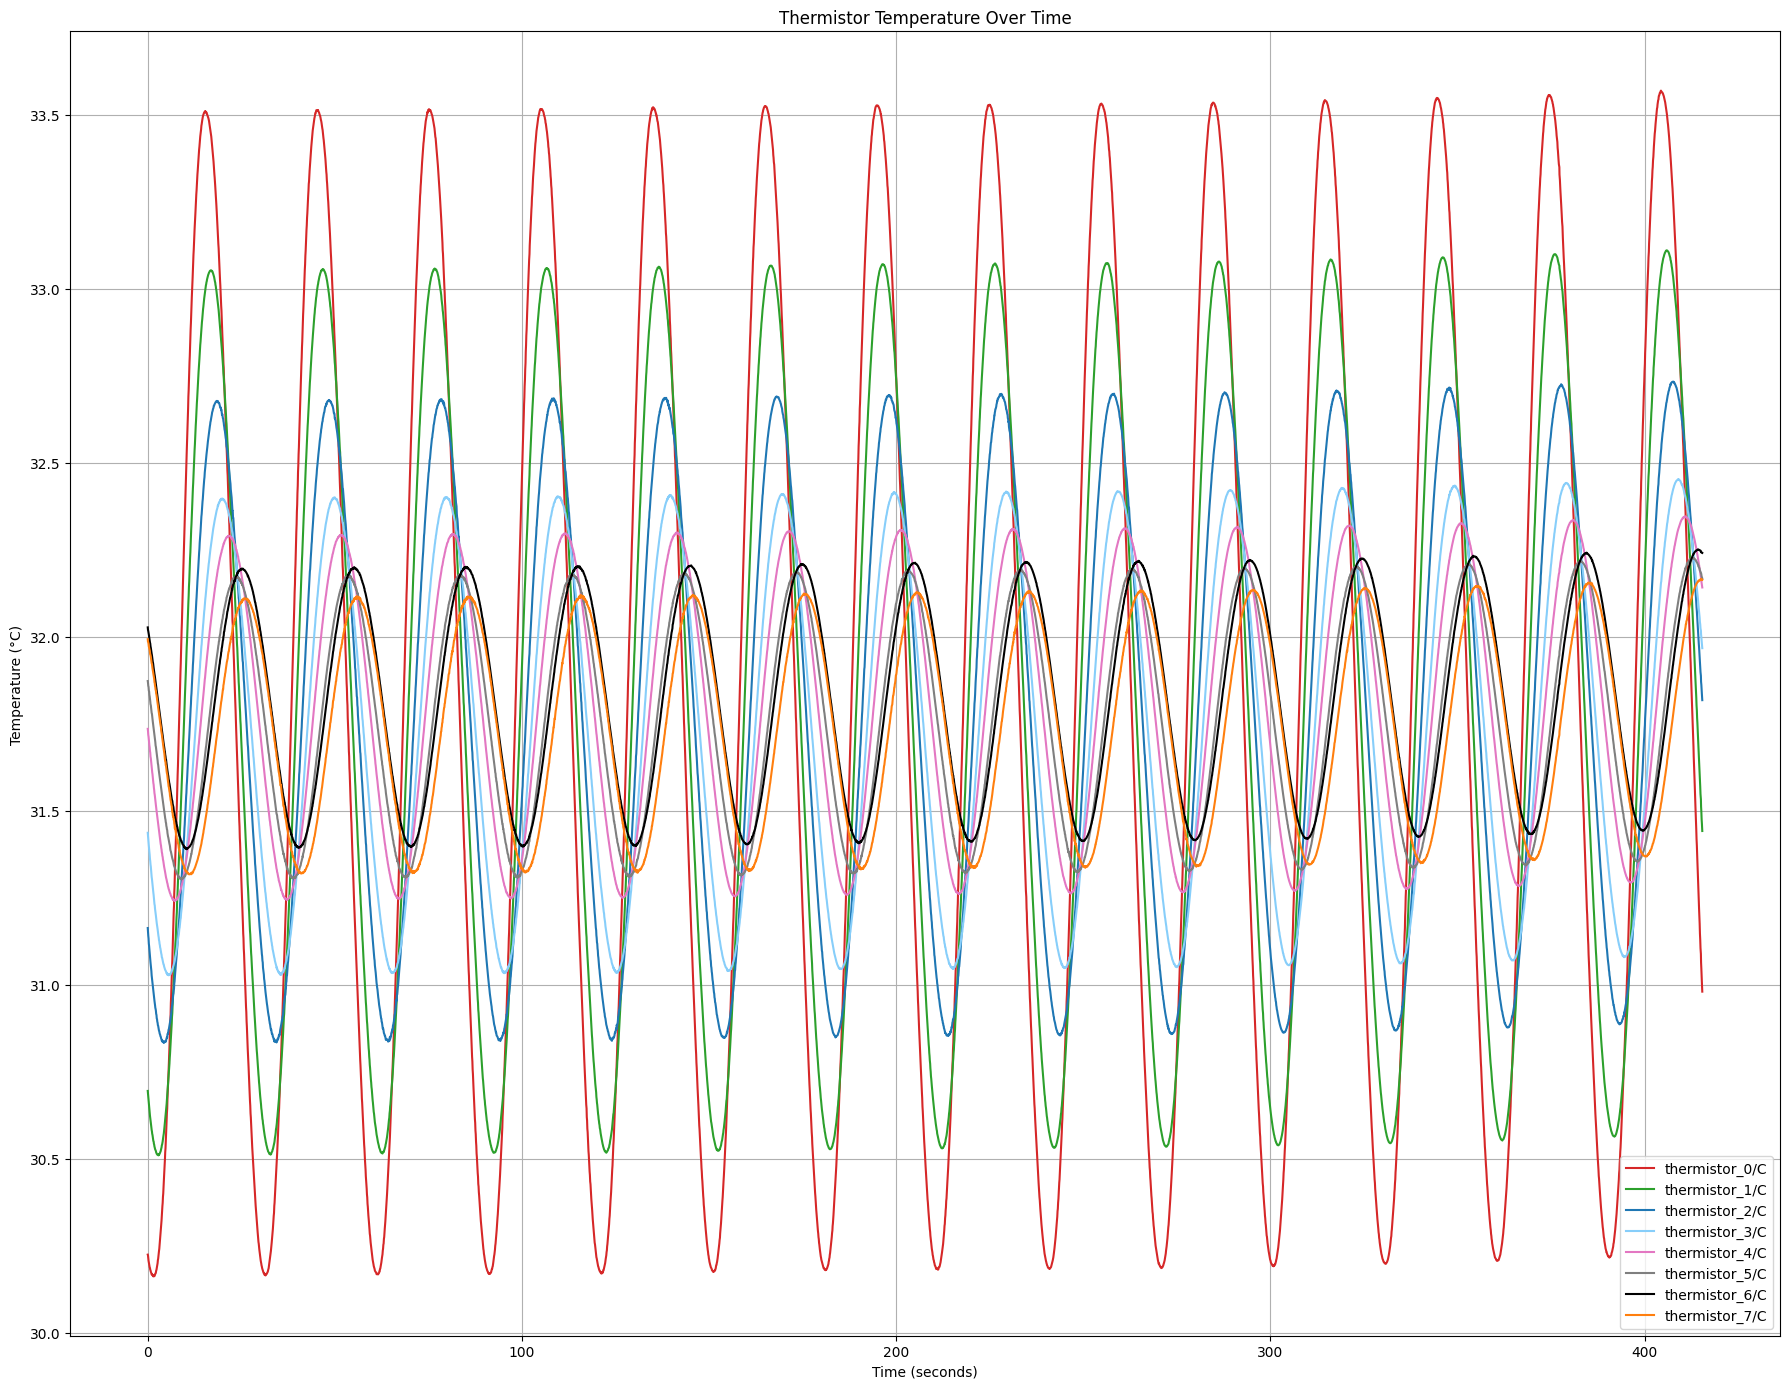

In [77]:
colors = ['tab:red', 'tab:green', 'tab:blue', 'lightskyblue', 
          'tab:pink', 'tab:gray', 'black', 'tab:orange']

plt.figure(figsize=(18, 14))

# Plot each thermistor's data with a different color and label
for i in range(8):
    plt.plot(timestamp, thermistor_temperatures[:,i], label=thermistor_num[i], color=colors[i])

plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.title('Thermistor Temperature Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

x_positions = (3e-3 + np.arange(8)*5e-3)   
L = 0.041                                   
